# Compreensão do Problema

A inadimplência ocorre quando pessoas ou empresas deixam de pagar suas dívidas dentro do prazo, refletindo dificuldades financeiras e desequilíbrios no orçamento.<br>
No cenário econômico brasileiro atual, observa-se um aumento desse indicador, o que traz impactos negativos ao crédito e à economia em geral. Com o maior risco de não pagamento, as instituições financeiras tendem a restringir e encarecer o crédito, reduzindo o consumo e os investimentos.<br>
Diante desse contexto, o presente projeto tem como objetivos:<br>
1) Analisar a série histórica da inadimplência no Brasil;
2) Investigar a relação entre a inadimplência e variáveis macroeconômicas como Selic, crédito total, IPCA e PIB;
3) Desenvolver um modelo preditivo para estimar o comportamento da inadimplência.

In [1]:
# Importação das bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import StringIO
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Coleta de Dados

Os dados foram coletados diretamente da API do Banco Central do Brasil (Sistema SGS). As séries temporais selecionadas representam indicadores econômicos relevantes para a análise da inadimplência no país:

- Inadimplência - Código SGS: 21082;
- Crédito Total - Código SGS: 20786;
- Taxa Selic - Código SGS: 4189;
- IPCA - Código SGS: 433;

In [2]:
# Função para coletar e tratar séries temporais do Banco Central do Brasil (BCB)
def get_bcb_data_csv(codigo_serie, nome_coluna):
    # Monta o link da série no formato CSV 
    url_parts = ["https://api.bcb.gov.br/dados/serie/bcdata.sgs.", str(codigo_serie), "/dados?formato=csv"]
    url = "".join(url_parts)

    # Requisição dos dados ao servidor do Banco Central
    response = requests.get(url)
    response.raise_for_status()

    # Remoção de aspas e caracteres problemáticos
    text = response.text.replace('"', '').replace("'", '')

    # Leitura do CSV, ignorando linhas quebradas e erros de formatação
    df = pd.read_csv(StringIO(text), sep=';', on_bad_lines='skip', engine='python')

    # Verificação se as colunas esperadas existem
    expected_cols = {'data', 'valor'}
    if not expected_cols.issubset(set(df.columns.str.lower())):
        print("Aviso: série", codigo_serie, "não tem formato padrão. Colunas encontradas:", df.columns.tolist())
        return pd.DataFrame()  # retorna vazio se formato incorreto

    # Padronização do nome das colunas para letras minúsculas
    df.columns = df.columns.str.lower()

    # Conversão dos valores numéricos, trocando vírgulas por pontos e transformando em float
    df['valor'] = df['valor'].astype(str).str.replace(',', '.', regex=False).astype(float)
    
    # Conversão da coluna de datas para o formato datetime, considerando o padrão dia/mês/ano
    df['data'] = pd.to_datetime(df['data'], dayfirst=True)

    # Renomeação da coluna 'valor' para o nome passado como parâmetro
    df.rename(columns={'valor': nome_coluna}, inplace=True)

    # Retorna o DataFrame pronto para análise
    return df

In [3]:
# Coleta de séries temporais do Banco Central do Brasil (SGS)
inadimplencia = get_bcb_data_csv(21082, 'Inadimplência (%)')
credito = get_bcb_data_csv(20786, 'Crédito Total (R$ mi)')
selic = get_bcb_data_csv(4189, 'Selic (%)')
ipca = get_bcb_data_csv(433, 'IPCA (%)')

In [4]:
# Junção de todas as séries pela data
df_merged = (
    inadimplencia
    .merge(credito, on='data', how='inner')
    .merge(selic, on='data', how='inner')
    .merge(ipca, on='data', how='inner')
)

# Ordenação pela data
df_merged = df_merged.sort_values('data').reset_index(drop=True)

# Visualização das 5 primeiras linhas do DataFrame
df_merged.head()

,data,Inadimplência (%),Crédito Total (R$ mi),Selic (%),IPCA (%)
0,2011-03-01,3.17,25.93,11.62,0.79
1,2011-04-01,3.24,26.62,11.74,0.77
2,2011-05-01,3.37,26.46,11.92,0.47
3,2011-06-01,3.32,26.34,12.10,0.15
4,2011-07-01,3.42,26.54,12.25,0.16


Os datasets individuais foram mesclados em um único DataFrame consolidado, permitindo análises conjuntas entre inadimplência e variáveis macroeconômicas.

# Verificação dos Dados

In [5]:
# Verificação dos dados
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   data                   175 non-null    datetime64[ns]
 1   Inadimplência (%)      175 non-null    float64       
 2   Crédito Total (R$ mi)  175 non-null    float64       
 3   Selic (%)              175 non-null    float64       
 4   IPCA (%)               175 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 7.0 KB


Os tipos de dados estão adequados, com a data em formato datetime, e as demais variáveis no formato float.<br>
Não há valores nulos.

# Análise Exploratória dos Dados

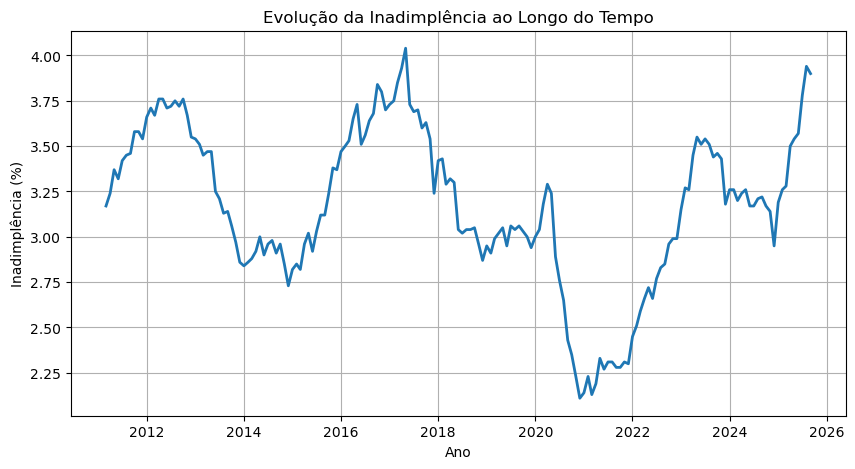

In [6]:
# Evolução da inadimplência ao longo do tempo
plt.figure(figsize=(10,5))
plt.plot(inadimplencia['data'], inadimplencia['Inadimplência (%)'], linewidth=2)
plt.title('Evolução da Inadimplência ao Longo do Tempo')
plt.xlabel('Ano')
plt.ylabel('Inadimplência (%)')
plt.grid(True)
plt.show()

Pode-se observar uma certa volatilidade na evolução da inadimplência ao longo do tempo, com ciclos de aumento seguidos por fases de estabilização. Nos períodos mais recentes, a inadimplência atingiu os níveis mais altos desde 2017, apresentando uma elevação acentuada em 2025.

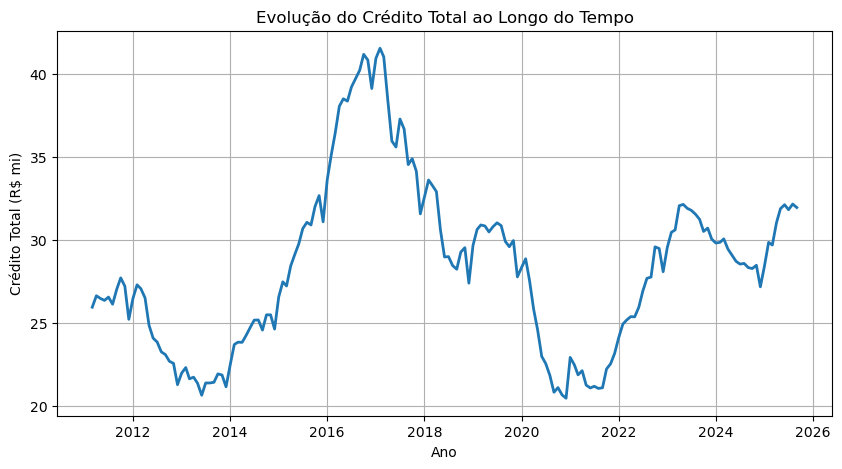

In [7]:
# Evolução do crédito total ao longo do tempo
plt.figure(figsize=(10,5))
plt.plot(credito['data'], credito['Crédito Total (R$ mi)'], linewidth=2)
plt.title('Evolução do Crédito Total ao Longo do Tempo')
plt.xlabel('Ano')
plt.ylabel('Crédito Total (R$ mi)')
plt.grid(True)
plt.show()

A trajetório do crédito total assemelha-se à da inadimplência. Com uma alta volatilidade ao longo tempo, níveis mais elevados em 2017, e uma tendência de alta a partir de 2021.

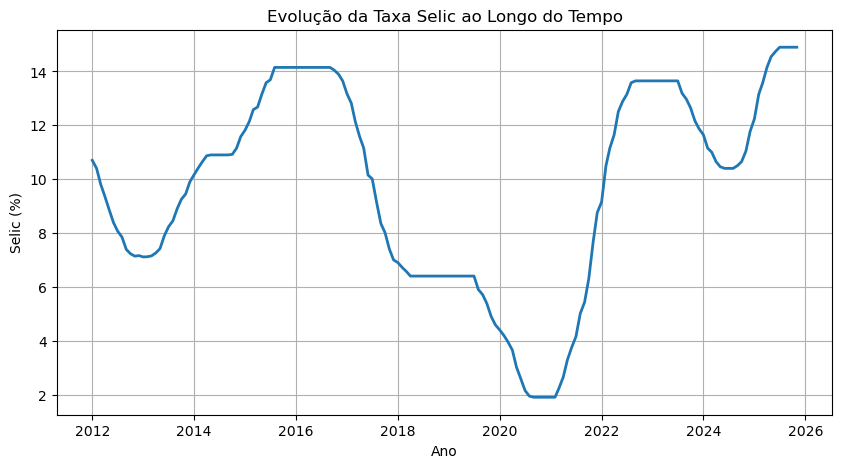

In [8]:
# Evolução do taxa SELIC ao longo do tempo
selic_2012 = selic[selic['data'].dt.year >= 2012]
plt.figure(figsize=(10,5))
plt.plot(selic_2012['data'], selic_2012['Selic (%)'], linewidth=2)
plt.title('Evolução da Taxa Selic ao Longo do Tempo')
plt.xlabel('Ano')
plt.ylabel('Selic (%)')
plt.grid(True)
plt.show()

A taxa SELIC também apresenta um comportamento cíclico. De 2015 a 2017 houve um período de contração monetária e um afrouxamento a partir de 2018.
A partir de 2021 é possível observar novamente o aumento da taxa, sendo que, atualmente está em 15% ao ano.

Conforme o Boletim Focus, divulgado em 14 de novembro de 2025, é esperado um período longo de contração monetária, com projeções para que a taxa tenha um leve recuo em 2026, para 12,25%.

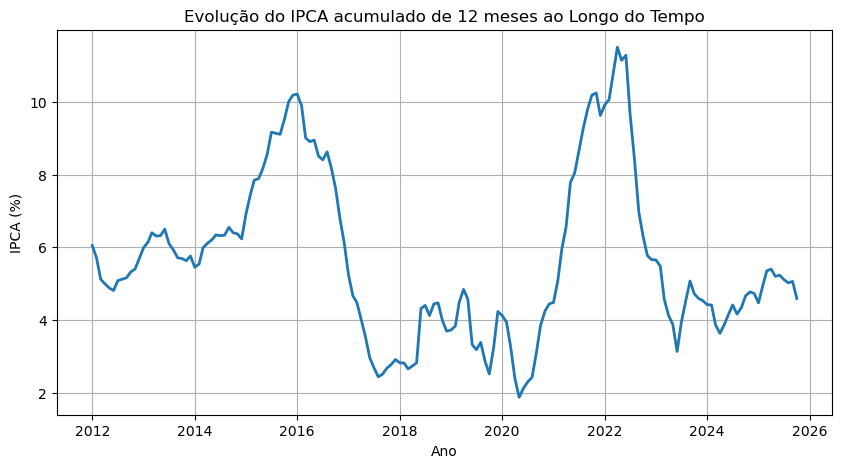

In [9]:
# Evolução do IPCA acumulado de 12 meses ao longo do tempo
ipca['ipca_12m'] = ipca['IPCA (%)'].rolling(12).sum()
ipca_2012 = ipca[ipca['data'].dt.year >= 2012]
plt.figure(figsize=(10,5))
plt.plot(ipca_2012['data'], ipca_2012['ipca_12m'], linewidth=2)
plt.title('Evolução do IPCA acumulado de 12 meses ao Longo do Tempo')
plt.xlabel('Ano')
plt.ylabel('IPCA (%)')
plt.grid(True)
plt.show()

Economicamente faz mais sentido analisar o IPCA acumulado de 12 meses, ao invés do índice mês a mês.

Ao estudar a evolução do IPCA é possível observar dois períodos de maiores picos: Em 2016 e 2022.

Atualmente o índice apresenta uma tendência de estabilização, mas ainda distante da meta de inflação de 3% ao ano, definida pelo Conselho Monetário Nacional.

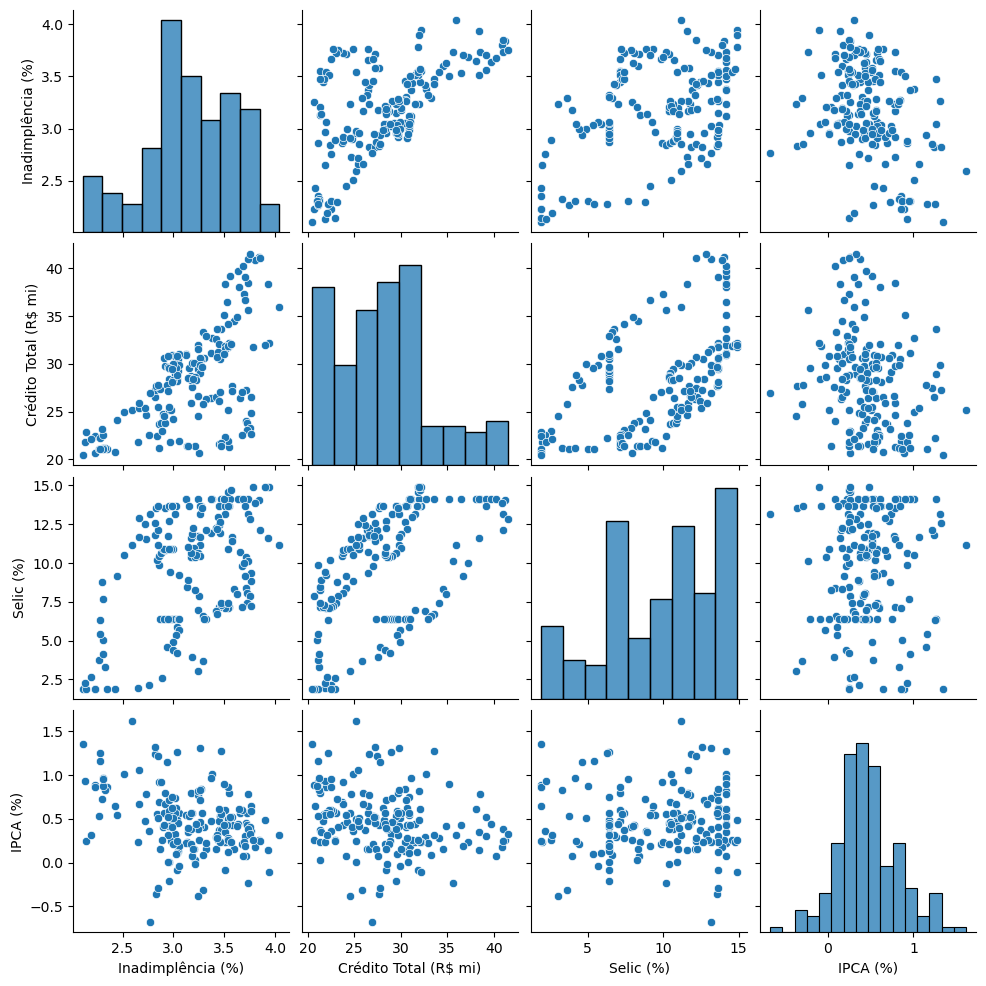

In [10]:
# Gráfico pairplot entre todas as variáveis
sns.pairplot(df_merged)

Inicialmente, é possível observar uma relação positiva tanto entre a inadimplência e a taxa Selic quanto entre a inadimplência e o volume total de crédito.

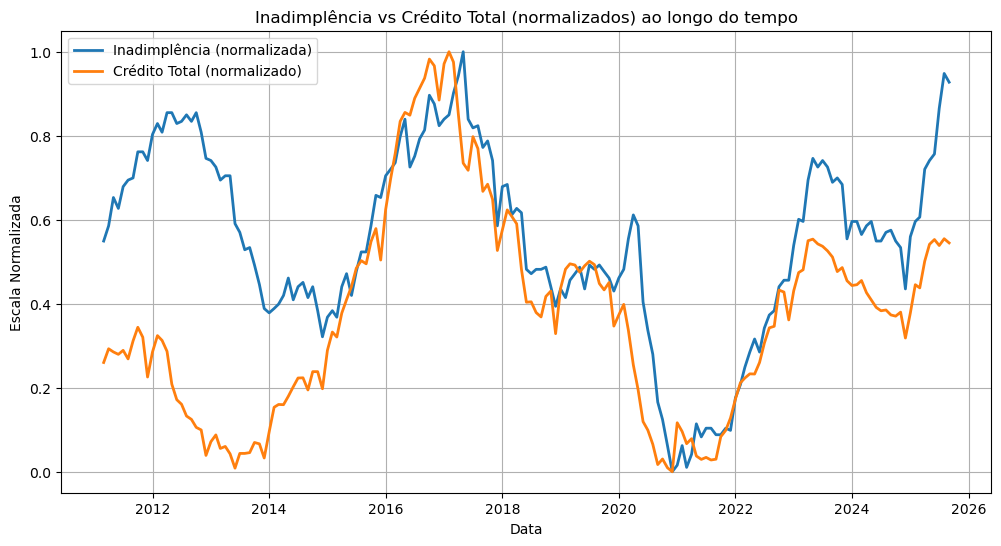

In [12]:
# Normalização das séries (0 a 1) para visualização
df_plot = df_merged.copy()
df_plot['inad_norm'] = (df_plot['Inadimplência (%)'] - df_plot['Inadimplência (%)'].min()) / \
                       (df_plot['Inadimplência (%)'].max() - df_plot['Inadimplência (%)'].min())

df_plot['credito_norm'] = (df_plot['Crédito Total (R$ mi)'] - df_plot['Crédito Total (R$ mi)'].min()) / \
                          (df_plot['Crédito Total (R$ mi)'].max() - df_plot['Crédito Total (R$ mi)'].min())

# Gráfico comparando as duas séries normalizadas
plt.figure(figsize=(12,6))
plt.plot(df_plot['data'], df_plot['inad_norm'], label='Inadimplência (normalizada)', linewidth=2)
plt.plot(df_plot['data'], df_plot['credito_norm'], label='Crédito Total (normalizado)', linewidth=2)
plt.title('Inadimplência vs Crédito Total (normalizados) ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Escala Normalizada')
plt.legend()
plt.grid(True)
plt.show()

É possível observar que, em vários momentos, as curvas avançam juntas, indicando que o aumento do volume de crédito vem acompanhado de maior nível de inadimplência. 

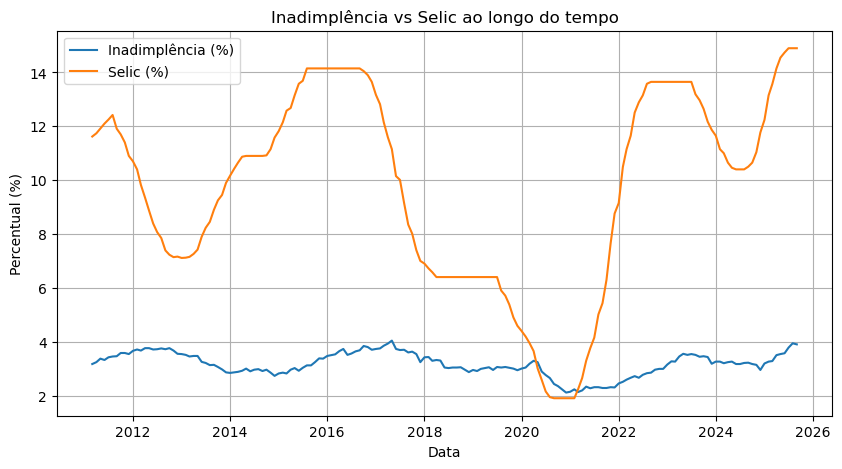

In [13]:
# Relação entre inadimplência e Taxa Selic ao longo do tempo
plt.figure(figsize=(10,5))
plt.plot(df_merged['data'], df_merged['Inadimplência (%)'], label='Inadimplência (%)')
plt.plot(df_merged['data'], df_merged['Selic (%)'], label='Selic (%)')
plt.legend()
plt.title('Inadimplência vs Selic ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Percentual (%)')
plt.grid(True)
plt.show()

É possível observar algumas similaridades entre a inadimplência e a Selic.<br>
Ambas têm seus pontos de máximo em 2017 e em 2025.<br>
Além disso, é possível observar que o ponto de mínima das duas variáveis foi em 2021. 

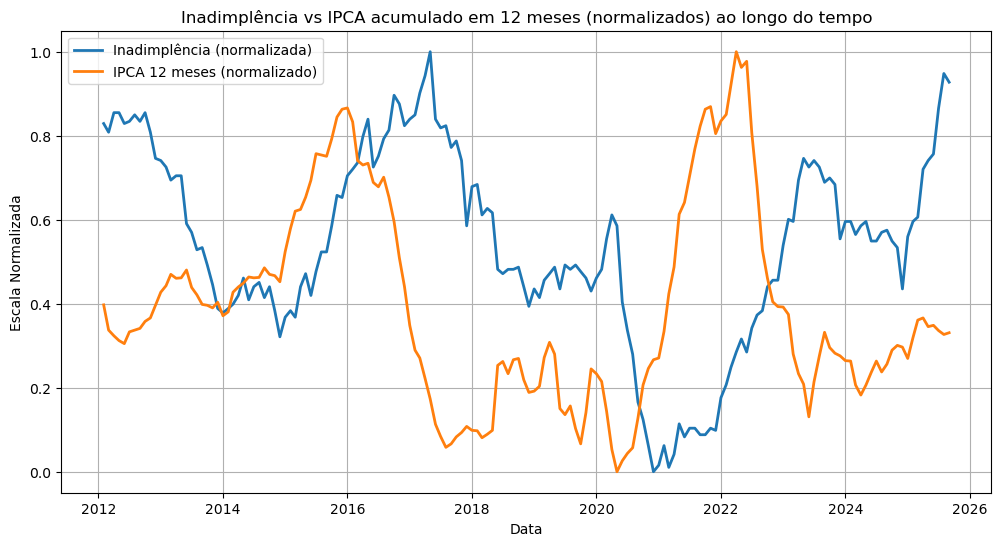

In [14]:
# Normalização para visualização
df_plot['ipca_12m'] = df_plot['IPCA (%)'].rolling(12).sum()

# Remover os 11 primeiros meses (sem acumulado completo)
df_plot = df_plot.dropna(subset=['ipca_12m']).reset_index(drop=True)

# Normalizar as duas séries (0 a 1) apenas para visualização
df_plot['inad_norm'] = (df_plot['Inadimplência (%)'] - df_plot['Inadimplência (%)'].min()) / \
                       (df_plot['Inadimplência (%)'].max() - df_plot['Inadimplência (%)'].min())

df_plot['ipca12_norm'] = (df_plot['ipca_12m'] - df_plot['ipca_12m'].min()) / \
                         (df_plot['ipca_12m'].max() - df_plot['ipca_12m'].min())

# Gráfico comparando as duas séries normalizadas
plt.figure(figsize=(12,6))
plt.plot(df_plot['data'], df_plot['inad_norm'], label='Inadimplência (normalizada)', linewidth=2)
plt.plot(df_plot['data'], df_plot['ipca12_norm'], label='IPCA 12 meses (normalizado)', linewidth=2)
plt.title('Inadimplência vs IPCA acumulado em 12 meses (normalizados) ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Escala Normalizada')
plt.legend()
plt.grid(True)
plt.show()

A inadimplência e o IPCA 12 meses caminham em sentidos diferentes na maior parte do tempo. Quando a inflação acelera, a inadimplência costuma recuar ou ficar estável; quando o IPCA cai após os picos, a inadimplência volta a subir. Isso mostra que as duas séries não se movem juntas e que o impacto da inflação na inadimplência não é imediato.

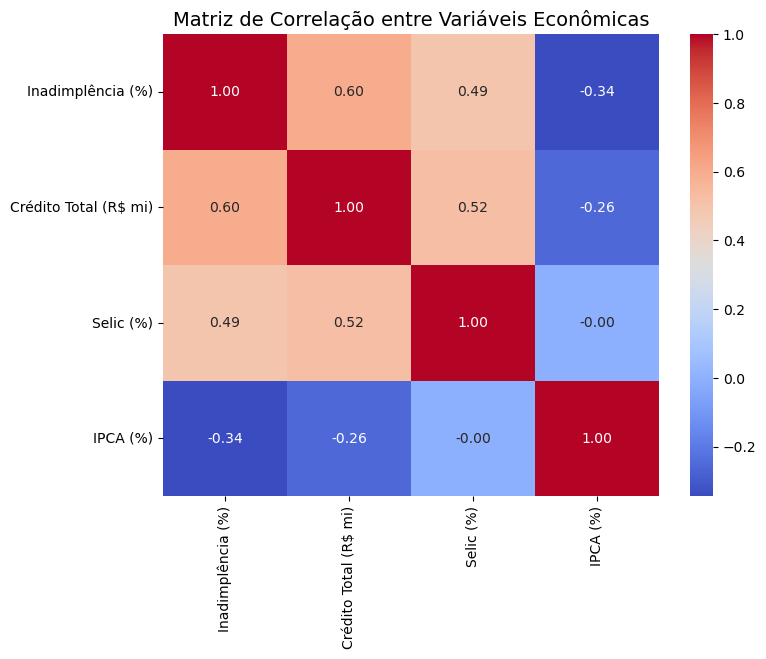

In [15]:
# Matriz de correlação
corr = df_merged.corr(numeric_only=True)
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação entre Variáveis Econômicas', fontsize=14)
plt.show()

A análise mostra que a inadimplência tem correlação moderada com o crédito total (0,60) e com a taxa Selic (0,49), indicando que o aumento dos juros e da oferta de crédito costuma vir acompanhado de maior risco de atraso nos pagamentos. Já a relação com o IPCA (-0,34) é negativa.

# Modelagem

In [16]:
# Criação de defasagens (lags) simples
df_ml = df_merged.copy()

In [17]:
# Remoção da coluna de data (XGBoost não aceita datetime)
df_ml = df_ml.drop(columns=['data'])

target = 'Inadimplência (%)'

df_ml['inad_lag1'] = df_ml[target].shift(1)
df_ml['inad_lag2'] = df_ml[target].shift(2)
df_ml['selic_lag1'] = df_ml['Selic (%)'].shift(1)
df_ml['credito_lag1'] = df_ml['Crédito Total (R$ mi)'].shift(1)
df_ml['ipca_lag1'] = df_ml['IPCA (%)'].shift(1)

df_ml = df_ml.dropna()

In [18]:
# Separação de X e y 
X = df_ml.drop(columns=[target])
y = df_ml[target]

In [19]:
# Divisão treino-teste (20% para teste)
test_size = int(0.2 * len(df_ml))
X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

Usei a divisão manual porque ela mantém a ordem temporal da série. O train_test_split embaralha os dados por padrão, o que não faz sentido quando queremos treinar com o passado e testar no futuro.

In [20]:
# Modelagem XGBoost
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

Esses hiperparâmetros foram utilizados pois deixam o XGBoost mais estável: o learning_rate baixo evita overfitting, o max_depth reduz sensibilidade a ruído e os 300 estimators ajudam a capturar as mudanças de tendência sem exagerar no ajuste.

In [24]:
#  Previsão
y_pred = model.predict(X_test)

# Avaliação

In [25]:
# Avaliação do modelo
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

RMSE: 0.1151
MAE: 0.0876


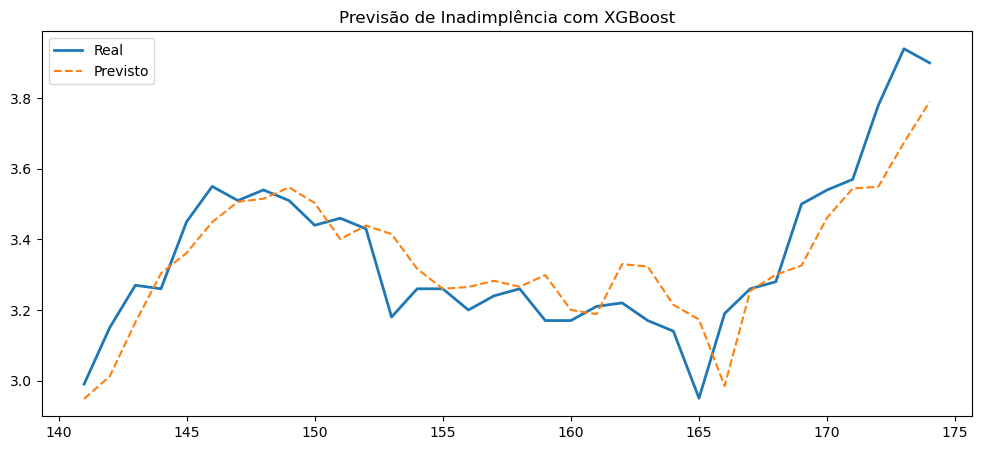

In [26]:
# Plot previsão vs real
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test, label='Real', linewidth=2)
plt.plot(y_test.index, y_pred, label='Previsto', linestyle='--')
plt.legend()
plt.title("Previsão de Inadimplência com XGBoost")
plt.show()

Os valores de RMSE: 0.1151 e MAE: 0.0876 indicam que o erro médio ficou em torno de 0,10 ponto percentual, o que é coerente para previsões de séries macroeconômicas mensais.<br>
É possível observar, a partir do gráfico, que o modelo acompanha de maneira consistente o movimento da série real, reproduzindo bem as mudanças de tendência e o comportamento geral.

## Conclusões


O modelo XGBoost apresentou um bom desempenho para uma abordagem simples, utilizando apenas defasagens e variáveis macroeconômicas. O erro médio baixo e a boa aderência visual sinalizam que o algoritmo foi capaz de capturar a dinâmica da inadimplência ao longo do tempo.

De modo geral:

- A inadimplência é influenciada por seus próprios valores passados;
- Variáveis macroeconômicas como Selic, IPCA e crédito total contribuem para o comportamento da série;
- Mesmo sem ajustes avançados, o XGBoost forneceu previsões consistentes.


Conclui-se, portanto, que modelos de machine learning podem auxiliar na interpretação e previsão de indicadores econômicos, servindo como ponto de partida para análises mais profundas.